# Separable segmentation

> The idea is to use a set of grouped convolution to perform the final segmentation in the last layer.

In [ ]:
import os; os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
from pathlib import Path
from itertools import product
from typing import Tuple

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
import cv2
import wandb
from wandb.keras import WandbCallback

## Data Loading

> We will be using CityScapes as a baseline.

The different training, validation and test subsets are divided in their correspondent folders:

In [ ]:
path_root = Path("/media/disk/databases/dn_segmentation/cityscapes")
path_train = path_root / "train_data"
path_val = path_root / "validation_data"
path_test = path_root / "test_data"

We will now build a set of generators to load the data:

In [ ]:
def get_label_path_from_img(path_img):
    path_label = str(path_img).split("_")
    path_label[-1] = "gtFine_color.png"
    path_label = "_".join(path_label)
    path_label = path_label.replace("images", "labels")
    path_label = Path(path_label)
    return path_label

In [ ]:
def train_gen():
    for path_img in (path_train/"images").glob("*.png"):
        path_label = get_label_path_from_img(path_img)

        ## Load the images
        img = cv2.imread(str(path_img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, dsize=(256,128))
        label = cv2.imread(str(path_label))
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
        label = cv2.resize(label, dsize=(256,128), interpolation=cv2.INTER_NEAREST)
        yield img, label

In [ ]:
def val_gen():
    for path_img in (path_val/"images").glob("*.png"):
        path_label = get_label_path_from_img(path_img)

        ## Load the images
        img = cv2.imread(str(path_img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, dsize=(256,128))
        label = cv2.imread(str(path_label))
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
        label = cv2.resize(label, dsize=(256,128), interpolation=cv2.INTER_NEAREST)
        yield img, label

In [1]:
a, b = next(train_gen())
a.shape, b.shape

((128, 256, 3), (128, 256, 3))

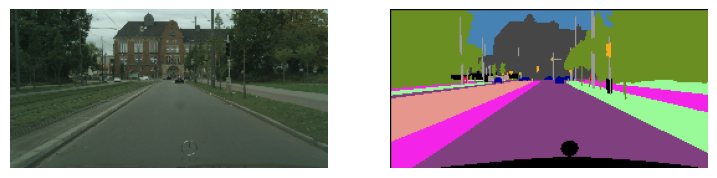

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(9,4))

axes[0].imshow(a)
axes[1].imshow(b)
for ax in axes: ax.axis("off")
plt.show()

### Turn the labels into a sparse representation

> The labels are loaded as colors, but now we need to turn them into sparse representations to be able to train our network.

First we will be obtaining the individual colors in the images:

In [2]:
colors = np.array([(0, 0, 0), (111, 74, 0), (81, 0, 81), (128, 64, 128), (244, 35, 232), (250, 170, 160), (230, 150, 140), (70, 70, 70), 
                   (102, 102, 156), (190, 153, 153), (180, 165, 180), (150, 100, 100), (150, 120, 90), (153, 153, 153), (250, 170, 30), (220, 220, 0), (107, 142, 35), 
                   (152, 251, 152), (70, 130, 180), (220, 20, 60), (255, 0, 0), ( 0, 0, 142), ( 0, 0, 70), (0, 60, 100), (0, 0, 90), (0, 0, 110), (0, 80, 100), (0, 0, 230), 
                   (119, 11, 32), (0, 0, 142)], dtype = np.int32)
colors = set([tuple(c) for c in colors])
len(colors)

29

Now we can build a dictionary mapping each color into one integer:

In [3]:
color2label = {color:i for i,color in enumerate(colors)}
label2color = {i:color for i,color in enumerate(colors)}
len(color2label)#, label2color

29

Finally, we can convert the label:

In [ ]:
def prepare_label(label):
    new_label = np.empty(shape=label.shape[:-1])
    for i, j in product(range(label.shape[0]), range(label.shape[1])):
        color = label[i,j]
        new_label[i,j] = color2label[tuple(color)]
    return new_label

In [ ]:
def prepare_label_one_hot(label):
    new_label = np.zeros(shape=(*label.shape[:-1], len(colors)))
    for i, j in product(range(label.shape[0]), range(label.shape[1])):
        color = label[i,j]
        idx = color2label[tuple(color)]
        new_label[i,j,idx] = 1
    return new_label

In [ ]:
def one_hot_to_sparse(label):
    """Turns a one-hot encoded label into a sparse one."""
    return np.argmax(label, axis=-1)

## Building the `Dataset`

In [ ]:
def train_gen():
    for path_img in (path_train/"images").glob("*.png"):
        path_label = get_label_path_from_img(path_img)

        ## Load the images
        img = cv2.imread(str(path_img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, dsize=(256,128))
        label = cv2.imread(str(path_label))
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
        label = cv2.resize(label, dsize=(256,128), interpolation=cv2.INTER_NEAREST)

        ## Prepare the labels
        # label = prepare_label(label)
        label = prepare_label_one_hot(label)
        # label = tf.expand_dims(label, -1)
        
        yield img/255.0, label

In [ ]:
def val_gen():
    for path_img in (path_val/"images").glob("*.png"):
        path_label = get_label_path_from_img(path_img)

        ## Load the images
        img = cv2.imread(str(path_img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, dsize=(256,128))
        label = cv2.imread(str(path_label))
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)
        label = cv2.resize(label, dsize=(256,128), interpolation=cv2.INTER_NEAREST)

        ## Prepare the labels
        # label = prepare_label(label)
        label = prepare_label_one_hot(label)
        # label = tf.expand_dims(label, -1)
        
        yield img/255.0, label

In [4]:
a, b = next(train_gen())
a.shape, b.shape

((128, 256, 3), (128, 256, 29))

In [ ]:
dst_train = tf.data.Dataset.from_generator(
                            train_gen,
                            output_signature=(
                                tf.TensorSpec(a.shape, tf.float32),
                                tf.TensorSpec(b.shape, tf.int32),
                            ))

In [ ]:
dst_val = tf.data.Dataset.from_generator(
                            val_gen,
                            output_signature=(
                                tf.TensorSpec(a.shape, tf.float32),
                                tf.TensorSpec(b.shape, tf.int32),
                            ))

## Defining the model

> The important part is going to be at the last part of the model.

In [ ]:
config = {
    "batch_size": 64,
    "epochs": 50,
    "pre_last_activation": "sigmoid"
}

In [ ]:
wandb.init(project="segmentation_test",
           name="Sigmoid",
           config=config)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jorgvt. Use `wandb login --relogin` to force relogin


In [ ]:
# inputs = tf.keras.Input(shape=(1024,2048,3))
inputs = tf.keras.Input(shape=(128, 256,3))
# resize = layers.Resizing(128, 256)
conv1_e = layers.Conv2D(32, kernel_size=5, strides=1, padding="same", activation="relu")
conv2_e = layers.Conv2D(64, kernel_size=5, strides=1, padding="same", activation="relu")
conv3_e = layers.Conv2D(128, kernel_size=5, strides=1, padding="same", activation="relu")
pooling = layers.MaxPooling2D(2)
upsampling = layers.UpSampling2D(2)
conv2_d = layers.Conv2D(32, kernel_size=5, strides=1, padding="same", activation="relu")
conv1_d = layers.Conv2D(len(color2label)*3, kernel_size=5, strides=1, padding="same", activation=config.pre_last_activation)
classifier = layers.Conv2D(len(color2label), kernel_size=1, groups=len(color2label), strides=1, padding="same", activation="softmax")

## Encoder
# inputs_resized = resize(inputs)
# output_1e = conv1_e(inputs_resized)
output_1e = conv1_e(inputs)
output_2e = conv2_e(pooling(output_1e))
output_3e = conv3_e(pooling(output_2e))

## Decoder

upsampled_3 = upsampling(output_3e)
output_2d = conv2_d(tf.concat([output_2e, upsampled_3], axis=-1))
upsampled_2 = upsampling(output_2d)
output_1d = conv1_d(tf.concat([output_1e, upsampled_2], axis=-1))

## Separable classifier
output_final = classifier(output_1d)

## Model
model = tf.keras.Model(inputs, output_final)
model.compile(optimizer="adam",
              loss=tf.losses.CategoricalCrossentropy(from_logits=False),
              # loss="mae",
              metrics=["accuracy",
                    #    tf.keras.metrics.IoU(num_classes=len(colors),
                    #                         target_class_ids=list(range(len(colors)))),
                       ])

## Training the model

In [ ]:
def prepare_masks_wandb(image, 
                        label, # one-hot encoeded.
                        pred, # one-hot encoeded.,
                        class_labels,
                        ):
    label = one_hot_to_sparse(label)
    pred = one_hot_to_sparse(pred)
    mask_img = wandb.Image(image, masks={
        "predictions": {
            "mask_data": pred,
            "class_labels": class_labels
        },
        "ground_truth": {
            "mask_data": label,
            "class_labels": class_labels,
        }
        })
    return mask_img


In [ ]:
class SegmentationMaskLogger(tf.keras.callbacks.Callback):
    """Callback to log the segmentation masks properly into WandB."""

    def __init__(self, 
                 data: Tuple, # (X, Y) tuple.
                 prefix: str = "",
                 ):
        self.data = data
        self.prefix = prefix
        self.class_labels = {k:str(v) for k,v in label2color.items()}
    
    def on_epoch_end(self,
                     epoch,
                     logs=None,
                     ):
        preds = model.predict(self.data[0], verbose=0)
        results = [prepare_masks_wandb(X, Y, pred, self.class_labels) for X, Y, pred in zip(self.data[0], self.data[1], preds)]
        wandb.log({f"{self.prefix}results":results})

In [ ]:
history = model.fit(dst_train.batch(config.batch_size), epochs=config.epochs,
                    validation_data=dst_val.batch(config.batch_size),
                    callbacks=[WandbCallback(monitor="val_loss",
                                             mode="min",
                                             save_weights_only=True,
                                             ),
                    SegmentationMaskLogger(data=dst_train.batch(8).take(1).get_single_element(), prefix="train_"),
                    SegmentationMaskLogger(data=dst_val.batch(8).take(1).get_single_element(), prefix="val_"),
                    ])

Epoch 1/50
47/47 [==============================] - 1228s 26s/step - loss: 3.0833 - accuracy: 0.0846 - val_loss: 3.0056 - val_accuracy: 0.0963
Epoch 2/50
47/47 [==============================] - 1037s 22s/step - loss: 2.9589 - accuracy: 0.0855 - val_loss: 2.9044 - val_accuracy: 0.0963
Epoch 3/50
47/47 [==============================] - 1037s 22s/step - loss: 2.8606 - accuracy: 0.1123 - val_loss: 2.8120 - val_accuracy: 0.1999
Epoch 4/50
47/47 [==============================] - 1022s 22s/step - loss: 2.7612 - accuracy: 0.2103 - val_loss: 2.7108 - val_accuracy: 0.1999
Epoch 5/50
47/47 [==============================] - 1020s 22s/step - loss: 2.6606 - accuracy: 0.2103 - val_loss: 2.6214 - val_accuracy: 0.1999
Epoch 6/50
47/47 [==============================] - 1025s 22s/step - loss: 2.5741 - accuracy: 0.2104 - val_loss: 2.5445 - val_accuracy: 0.2001
Epoch 7/50
47/47 [==============================] - 1034s 22s/step - loss: 2.4792 - accuracy: 0.4349 - val_loss: 2.4333 - val_accuracy: 0.4894

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
INFO:tensorflow:Assets written to: /media/disk/users-muten/vitojor/CycleGTA/01_Segmentation/wandb/run-20221128_095332-cggcffhq/files/model-best/assets
wandb: Adding directory to artifact (/media/disk/users-muten/vitojor/CycleGTA/01_Segmentation/wandb/run-20221128_095332-cggcffhq/files/model-best)... Done. 0.2s
INFO:tensorflow:Assets written to: /media/disk/users-muten/vitojor/CycleGTA/01_Segmentation/wandb/run-20221128_095332-cggcffhq/files/model-best/assets
wandb: Adding directory to artifact (/media/disk/users-muten/vitojor/CycleGTA/01_Segmentation/wandb/run-20221128_095332-cggcffhq/files/model-best)... Done. 0.2s
INFO:tensorflow:Assets written to: /media/di

In [ ]:
wandb.finish()

accuracy,0.8134
best_epoch,49
best_val_loss,0.80496
epoch,49
loss,0.75429
val_accuracy,0.79757
val_loss,0.80496
